# **Import the Necessary Libraries**

In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Lambda, MultiHeadAttention, Dropout, LayerNormalization, Dense
from tensorflow.keras import Sequential
from keras import layers, ops

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

2026-02-14 19:53:21.289375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771098801.457339      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771098801.508779      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **EDA (Exploratory Data Analysis)**

In [2]:
df = pd.read_csv("/kaggle/input/turkish-words-roots-suffixes.csv")

df.head()

,word,root,suffixes
0,alıyorum,al,ıyorum
1,görmek,gör,mek
2,dersin,ders,in
3,şiddetli,şiddet,li
4,yumurtalar,yumurta,lar


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18545 entries, 0 to 18544
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   word      18545 non-null  object
 1   root      18545 non-null  object
 2   suffixes  16388 non-null  object
dtypes: object(3)
memory usage: 434.8+ KB


## **Style and Helpers**

In [4]:
# Customize Seaborn plot theme and matplotlib settings
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.dpi"] = 120

# Helper function to annotate bar plots with counts
def annotate_bars(ax):
	for p in ax.patches:
		width = p.get_width()
		if width is None:
			continue
        # Display the count value inside/next to the bar    
		ax.annotate(f"{int(width)}", (p.get_x() + width, p.get_y() + p.get_height() / 2),
		            xytext=(5, 0), textcoords="offset points", va="center", ha="left", fontsize=15, color="#333")

# Add a vertical dashed line at the median value for hist/distribution plots
def median_vline(ax, data, color="#aa0000", label="Median"):
	med = np.median(data)
	ax.axvline(med, color=color, linestyle="--", linewidth=2, label=f"{label}: {med:.0f}")
	ax.legend()

# Formatter for pie charts to show both percentage and count
def autopct_counts(values):
	total = np.sum(values)
	def inner(pct):
		count = int(round(pct * total / 100.0))
		return f"{pct:.1f}%\n({count})"
	return inner

## **Basic Cleaning and Helper Columns**

In [5]:
def normalize_string(x):
    # Convert None/NaN → np.nan; if it's a string, strip leading/trailing whitespaces
	if pd.isna(x):
		return np.nan
	if isinstance(x, str):
		return x.strip()
	return x

def safe_length(x):
    # Return 0 if NaN; otherwise return the length of the string representation
	return 0 if pd.isna(x) else len(str(x))

df['word']     = df['word'].apply(normalize_string)
df['root']     = df['root'].apply(normalize_string)
df['suffixes'] = df['suffixes'].apply(normalize_string)

# Missing/duplicate checks
missing_counts = df[['word','root','suffixes']].isna().sum()
print("Missing value counts:\n", missing_counts, "\n")

num_duplicates = df.duplicated(subset=['word','root','suffixes']).sum()
print(f"Exact-duplicate row count: {num_duplicates}\n")

# Length columns
df['word_len']   = df['word'].apply(safe_length)
df['root_len']   = df['root'].apply(safe_length)
df['suffix_len'] = df['suffixes'].apply(safe_length)

Missing value counts:
 word           0
root           0
suffixes    2157
dtype: int64 

Exact-duplicate row count: 532



## **Longest / Shortest (Word, Root, Suffix)**

In [6]:
def longest_shortest(df, col, len_col, label):
	max_len = df[len_col].max()
	min_len = df[len_col].min()
	long_rows = df[df[len_col] == max_len][[col, len_col]].drop_duplicates()
	short_rows = df[df[len_col] == min_len][[col, len_col]].drop_duplicates()
	print(f"{label} - Max length: {max_len}, examples: {len(long_rows)}")
	print(long_rows.head(20).to_string(index=False), "\n")
	print(f"{label} - Min length: {min_len}, examples: {len(short_rows)}")
	print(short_rows.head(20).to_string(index=False), "\n")

print("=== Longest / Shortest ===\n")
longest_shortest(df, 'word', 'word_len', "Word")
longest_shortest(df, 'root', 'root_len', "Root")
# Note: NaN suffix treated as length 0
longest_shortest(df, 'suffixes', 'suffix_len', "Suffix")

=== Longest / Shortest ===

Word - Max length: 34, examples: 1
                              word  word_len
sömürgeleştiremediklerimizdensiniz        34 

Word - Min length: 1, examples: 1
word  word_len
   o         1 

Root - Max length: 11, examples: 8
       root  root_len
sırılsıklam        11
northumbria        11
başpiskopos        11
motorsiklet        11
bulgaristan        11
mütemadiyen        11
çırılçıplak        11
kompartıman        11 

Root - Min length: 1, examples: 1
root  root_len
   o         1 

Suffix - Max length: 29, examples: 1
                     suffixes  suffix_len
geleştiremediklerimizdensiniz          29 

Suffix - Min length: 0, examples: 1
suffixes  suffix_len
     NaN           0 



##  **Length Distributions and Summary Stats**

=== Length statistics ===

Word length stats:
count    18545.00000
mean         8.43381
std          2.66149
min          1.00000
25%          7.00000
50%          8.00000
75%         10.00000
max         34.00000
Name: word_len, dtype: float64

Root length stats:
count    18545.000000
mean         4.287894
std          1.552329
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         11.000000
Name: root_len, dtype: float64

Suffix length stats:
count    18545.000000
mean         4.155675
std          2.707876
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         29.000000
Name: suffix_len, dtype: float64



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


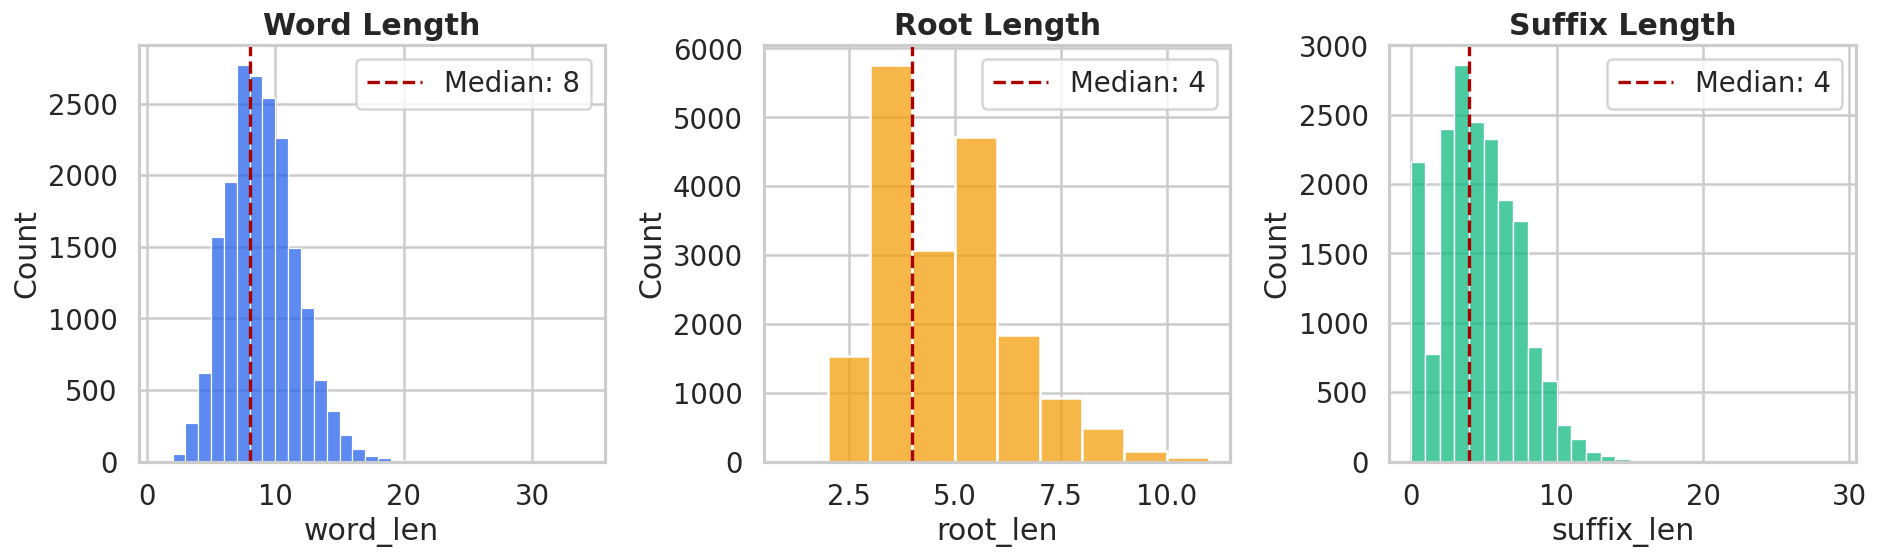

In [7]:
def describe_lengths(series, label):
	desc = series.describe(percentiles=[0.25, 0.5, 0.75])
	print(f"{label} length stats:\n{desc}\n")

print("=== Length statistics ===\n")
describe_lengths(df['word_len'], "Word")
describe_lengths(df['root_len'], "Root")
describe_lengths(df['suffix_len'], "Suffix")

# Histograms (bin width = 1, median line)
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
ax1 = sns.histplot(df['word_len'], binwidth=1, kde=False, color="#2563eb", edgecolor="white")
plt.title("Word Length")
median_vline(ax1, df['word_len'])

plt.subplot(1,3,2)
ax2 = sns.histplot(df['root_len'], binwidth=1, kde=False, color="#f59e0b", edgecolor="white")
plt.title("Root Length")
median_vline(ax2, df['root_len'])

plt.subplot(1,3,3)
ax3 = sns.histplot(df['suffix_len'], binwidth=1, kde=False, color="#10b981", edgecolor="white")
plt.title("Suffix Length")
median_vline(ax3, df['suffix_len'])
plt.tight_layout()
plt.show()

##  **No-Suffix Words and Suffix-Length Buckets (Pie Chart)**

=== Suffix length buckets ===

Bucket counts:
 suffix_bucket
0      2157
1       774
2      2394
3      2861
4+    10359
Name: count, dtype: int64 

No-suffix (NaN/empty) word count: 2157
No-suffix ratio: 11.63%



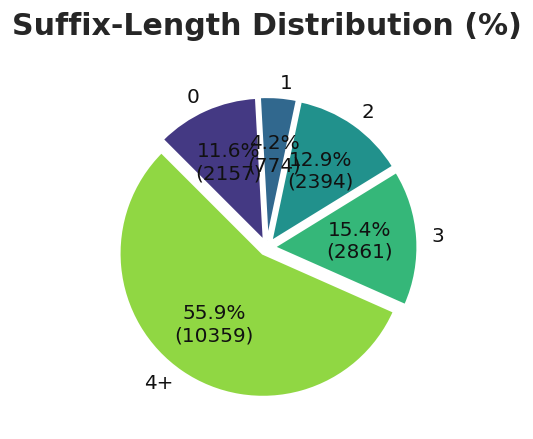

In [8]:
print("=== Suffix length buckets ===\n")
def bucket_suffix_len(n):
	if n == 0:
		return "0"
	if n == 1:
		return "1"
	if n == 2:
		return "2"
	if n == 3:
		return "3"
	return "4+"

df['suffix_bucket'] = df['suffix_len'].apply(bucket_suffix_len)
bucket_counts = df['suffix_bucket'].value_counts().reindex(["0","1","2","3","4+"], fill_value=0)
print("Bucket counts:\n", bucket_counts, "\n")
print(f"No-suffix (NaN/empty) word count: {bucket_counts['0']}")
print(f"No-suffix ratio: {bucket_counts['0'] / len(df):.2%}\n")

colors = sns.color_palette("viridis", n_colors=5)
plt.figure(figsize=(4,4))
plt.pie(
	bucket_counts.values,
	labels=bucket_counts.index,
	colors=colors,
	startangle=135,
	counterclock=False,
	explode=[0.05, 0.05, 0.05, 0.05, 0.05],
	shadow=False,
	autopct=autopct_counts(bucket_counts.values),
	textprops={"color":"#111", "fontsize":12}
)
plt.title("Suffix-Length Distribution (%)", pad=20)
plt.tight_layout()
plt.show()

##  **Frequencies: Visualization of Top Roots and Suffixes**

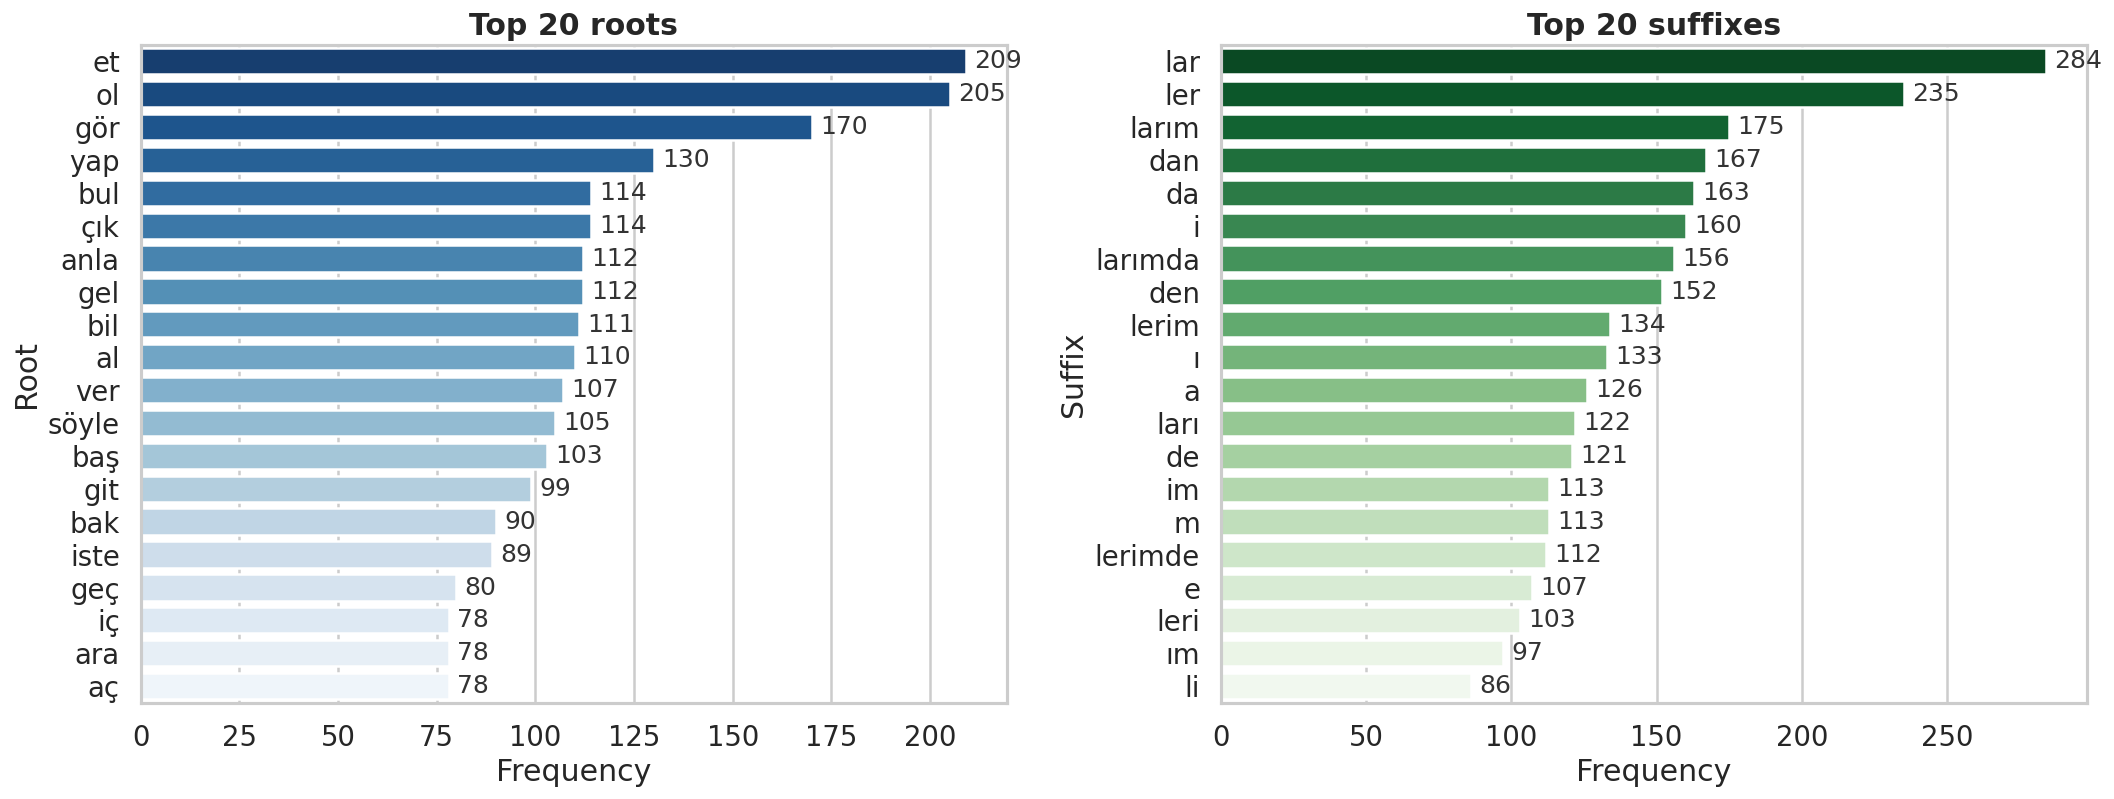

In [9]:
top_n = 20

root_freq = df['root'].value_counts().head(top_n)
suffix_freq = df['suffixes'].dropna().value_counts().head(top_n)

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
ax = sns.barplot(y=root_freq.index, x=root_freq.values, palette="Blues_r")
plt.title(f"Top {top_n} roots")
plt.xlabel("Frequency")
plt.ylabel("Root")
annotate_bars(ax)

plt.subplot(1,2,2)
ax = sns.barplot(y=suffix_freq.index, x=suffix_freq.values, palette="Greens_r")
plt.title(f"Top {top_n} suffixes")
plt.xlabel("Frequency")
plt.ylabel("Suffix")
annotate_bars(ax)

plt.tight_layout()
plt.show()

# **Settings / Hyperparameters**

In [10]:
DATA_PATH = "/kaggle/input/turkish-words-roots-suffixes.csv"

START_TOKEN = "<"
END_TOKEN = ">"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
EMBED_DIM = 128
NUM_HEADS = 4
KEY_DIM = EMBED_DIM // NUM_HEADS
FF_DIM = 512
DROPOUT_RATE = 0.1

EPOCHS = 50
BATCH_SIZE = 64
RANDOM_STATE = 42
LABEL_SMOOTHING = 0.1
LEARNING_RATE = 5e-4

BEAM_SIZE = 5

CHECKPOINT_WEIGHTS = "best_rootfinder.weights.h5"

# **Preprocessing**

In [11]:
# Load data again
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=["word", "root"]).reset_index(drop=True)
df = df.drop_duplicates(subset=['word','root','suffixes'], keep='first').reset_index(drop=True)
df["word"] = df["word"].astype(str)
df["root"] = df["root"].astype(str)
df["input"] = df["word"]
df["target_raw"] = df["root"]
df["target"] = df["target_raw"].apply(lambda r: START_TOKEN + r + END_TOKEN)

print("Sample data:")
print(df.head())
print("\n\nInfo about dataset:")
print(df.info())

Sample data:
         word     root suffixes       input target_raw     target
0    alıyorum       al   ıyorum    alıyorum         al       <al>
1      görmek      gör      mek      görmek        gör      <gör>
2      dersin     ders       in      dersin       ders     <ders>
3    şiddetli   şiddet       li    şiddetli     şiddet   <şiddet>
4  yumurtalar  yumurta      lar  yumurtalar    yumurta  <yumurta>


Info about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18013 entries, 0 to 18012
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   word        18013 non-null  object
 1   root        18013 non-null  object
 2   suffixes    15967 non-null  object
 3   input       18013 non-null  object
 4   target_raw  18013 non-null  object
 5   target      18013 non-null  object
dtypes: object(6)
memory usage: 844.5+ KB
None


In [12]:
# GLOBAL ROOT FREQUENCY 
from collections import Counter

ROOT_FREQ = Counter(df["root"])
print(f"Total unique roots: {len(ROOT_FREQ)}")
print(f"Top 10 most frequent roots:")
for root, count in ROOT_FREQ.most_common(10):
    print(f"  {root}: {count}")

Total unique roots: 3091
Top 10 most frequent roots:
  et: 202
  ol: 189
  gör: 161
  yap: 125
  anla: 111
  çık: 109
  bul: 109
  al: 108
  gel: 106
  söyle: 104


##  **Character-Level Vocabulary and Tokenization**

In [13]:
# Build character-level vocab
all_chars = sorted(set(''.join(df["input"].values) + ''.join(df["target"].values)))

# Initialize char-to-index and index-to-char dictionaries with PAD and UNK tokens
char2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
idx2char = {0: PAD_TOKEN, 1: UNK_TOKEN}
for i, ch in enumerate(all_chars, start=2):
    char2idx[ch] = i
    idx2char[i] = ch
vocab_size = len(char2idx)

# Tokenizer function: converts a string into a list of token IDs, with padding/truncation
def tokenize_to_ids(text, maxlen):
    ids = [char2idx.get(ch, char2idx[UNK_TOKEN]) for ch in text]
    if len(ids) > maxlen:
        ids = ids[:maxlen]
    else:
        ids += [char2idx[PAD_TOKEN]] * (maxlen - len(ids))
    return ids

# Determine maximum sequence lengths for encoder and decoder
max_encoder_len = df["input"].apply(len).max()
max_decoder_len = df["target"].apply(len).max()
print("Max encoder length:", max_encoder_len)
print("Max decoder length:", max_decoder_len)

# Example
example_word = df["input"][0]
example_target = df["target"][0]
print("\nExample word:", example_word)
print("Tokenized:", tokenize_to_ids(example_word, max_encoder_len))
print("Example target:", example_target)
print("Tokenized target:", tokenize_to_ids(example_target, max_decoder_len))

Max encoder length: 34
Max decoder length: 13

Example word: alıyorum
Tokenized: [5, 16, 34, 28, 19, 22, 25, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Example target: <al>
Tokenized target: [3, 5, 16, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
all_chars

["'",
 '<',
 '>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y',
 'z',
 'ç',
 'ö',
 'ü',
 'ğ',
 'ı',
 'ş']

In [15]:
char2idx

{'<PAD>': 0,
 '<UNK>': 1,
 "'": 2,
 '<': 3,
 '>': 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'k': 15,
 'l': 16,
 'm': 17,
 'n': 18,
 'o': 19,
 'p': 20,
 'q': 21,
 'r': 22,
 's': 23,
 't': 24,
 'u': 25,
 'v': 26,
 'w': 27,
 'y': 28,
 'z': 29,
 'ç': 30,
 'ö': 31,
 'ü': 32,
 'ğ': 33,
 'ı': 34,
 'ş': 35}

##  **Data Preparation for Seq2Seq**

In [16]:
# Encode input words: tokenize each input word and pad/truncate to max_encoder_len
encoder_input = np.array([tokenize_to_ids(w, max_encoder_len) for w in df["input"]], dtype=np.int32)

# Prepare decoder inputs and targets for teacher forcing
decoder_input_list = []
decoder_target_list = []
for t in df["target"]:
    dec_in = t[:-1]
    dec_tgt = t[1:]
    decoder_input_list.append(tokenize_to_ids(dec_in, max_decoder_len))
    decoder_target_list.append(tokenize_to_ids(dec_tgt, max_decoder_len))

decoder_input = np.array(decoder_input_list, dtype=np.int32)
decoder_target = np.array(decoder_target_list, dtype=np.int32)

# Split
words = df["input"].values
roots = df["target_raw"].values

(X_train_enc, X_val_enc,
 X_train_dec, X_val_dec,
 y_train, y_val,
 words_train, words_val,
 roots_train_raw, roots_val_raw) = train_test_split(
    encoder_input, decoder_input, decoder_target, words, roots,
    test_size=0.1, random_state=RANDOM_STATE
)

print("Encoder input shape:", X_train_enc.shape)
print("Decoder input shape:", X_train_dec.shape)

# Example
print("\nExample word:", example_word)
print("Encoder Input:", encoder_input[0])
print("Decoder Input:", decoder_input[0])
print("Decoder Target:", decoder_target[0])

Encoder input shape: (16211, 34)
Decoder input shape: (16211, 13)

Example word: alıyorum
Encoder Input: [ 5 16 34 28 19 22 25 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Decoder Input: [ 3  5 16  0  0  0  0  0  0  0  0  0  0]
Decoder Target: [ 5 16  4  0  0  0  0  0  0  0  0  0  0]


In [17]:
# INITIAL TRAIN/VAL SPLIT

(X_train_enc, X_val_enc, 
 X_train_dec, X_val_dec, 
 y_train, y_val,
 train_words, val_words,
 train_roots, val_roots) = train_test_split(
    encoder_input, decoder_input, decoder_target, words, roots,
    test_size=0.1, 
    random_state=RANDOM_STATE
)

print(f"Initial split - Train: {len(X_train_enc)}, Val: {len(X_val_enc)}")

Initial split - Train: 16211, Val: 1802


# **Transformer Model**

In [18]:
# Inputs
encoder_inputs = layers.Input(shape=(max_encoder_len,), dtype="int32", name="encoder_inputs")
decoder_inputs = layers.Input(shape=(max_decoder_len,), dtype="int32", name="decoder_inputs")

# Shared embedding
embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    mask_zero=True,
    name="char_embedding",
)
enc_emb = embedding(encoder_inputs)
dec_emb = embedding(decoder_inputs)

# Positional embeddings
pos_enc = layers.Embedding(input_dim=max_encoder_len, output_dim=EMBED_DIM, name="pos_enc")
pos_dec = layers.Embedding(input_dim=max_decoder_len, output_dim=EMBED_DIM, name="pos_dec")

enc_positions = tf.range(start=0, limit=max_encoder_len, delta=1)
dec_positions = tf.range(start=0, limit=max_decoder_len, delta=1)

enc_emb = enc_emb + pos_enc(enc_positions)   # (batch, enc_len, d)
dec_emb = dec_emb + pos_dec(dec_positions)   # (batch, dec_len, d)

# =======================
# Encoder mask
# =======================
enc_bool_mask = layers.Lambda(
    lambda x: ops.not_equal(x, 0),
    name="enc_bool_mask",
    output_shape=lambda s: s,   # (batch, enc_len)
)(encoder_inputs)

# MultiHeadAttention attention_mask shape:
# broadcastable to (batch, num_heads, query_len, key_len) or (batch, query_len, key_len)
# We provide (batch, 1, enc_len) which broadcasts with query_len in cross/enc attention.
enc_attn_mask = layers.Lambda(
    lambda m: ops.expand_dims(m, axis=1),       # (batch, 1, enc_len)
    name="enc_attn_mask",
    output_shape=lambda s: (s[0], 1, s[1]),
)(enc_bool_mask)

# =======================
# Decoder causal + padding mask
# =======================

# Create causal mask as a constant (computed once)
causal_mask_const = tf.linalg.band_part(
    tf.ones((max_decoder_len, max_decoder_len), dtype=tf.bool),
    -1,
    0,
)  # (L, L), lower triangular = True

def make_decoder_mask(x):
    # x: (batch, dec_len)
    dec_pad = ops.not_equal(x, 0)                # (batch, dec_len) bool
    dec_pad_1 = ops.expand_dims(dec_pad, -1)     # (batch, dec_len, 1)
    dec_pad_2 = ops.expand_dims(dec_pad, 1)      # (batch, 1, dec_len)

    causal = causal_mask_const                   # (L, L)
    causal = ops.expand_dims(causal, 0)          # (1, L, L) -> broadcast

    mask = ops.logical_and(dec_pad_1, dec_pad_2) # (batch, dec_len, dec_len)
    mask = ops.logical_and(mask, causal)         # (batch, dec_len, dec_len)
    return mask

dec_combined_mask = layers.Lambda(
    make_decoder_mask,
    name="dec_combined_mask",
    output_shape=lambda s: (s[0], s[1], s[1]),   # (batch, dec_len, dec_len)
)(decoder_inputs)


# --- Encoder stack ---
enc_x = enc_emb
for layer_idx in range(NUM_ENCODER_LAYERS):
    # Self-attention
    enc_self_attn = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=KEY_DIM,
        dropout=DROPOUT_RATE,
        name=f"enc_mha_{layer_idx}",
    )
    attn_out = enc_self_attn(
        query=enc_x,
        value=enc_x,
        key=enc_x,
        attention_mask=enc_attn_mask,  # (batch, 1, enc_len)
    )
    attn_out = layers.Dropout(DROPOUT_RATE)(attn_out)
    enc_x = layers.LayerNormalization(epsilon=1e-6)(attn_out + enc_x)

    # Feed-forward network
    enc_ffn = tf.keras.Sequential(
        [
            layers.Dense(FF_DIM, activation="relu"),
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(EMBED_DIM),
        ],
        name=f"enc_ffn_{layer_idx}",
    )
    ffn_out = enc_ffn(enc_x)
    enc_x = layers.LayerNormalization(epsilon=1e-6)(ffn_out + enc_x)

enc_final = enc_x

# --- Decoder stack ---
x = dec_emb
for layer_idx in range(NUM_DECODER_LAYERS):
    # Masked self-attention
    self_attn = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=KEY_DIM,
        dropout=DROPOUT_RATE,
        name=f"dec_self_attn_{layer_idx}",
    )
    sa_out = self_attn(
        query=x,
        value=x,
        key=x,
        attention_mask=dec_combined_mask,  # (batch, dec_len, dec_len)
    )
    sa_out = layers.Dropout(DROPOUT_RATE)(sa_out)
    sa_out = layers.LayerNormalization(epsilon=1e-6)(sa_out + x)

    # Cross-attention
    cross_attn = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=KEY_DIM,
        dropout=DROPOUT_RATE,
        name=f"dec_cross_attn_{layer_idx}",
    )
    ca_out = cross_attn(
        query=sa_out,
        value=enc_final,
        key=enc_final,
        attention_mask=enc_attn_mask,  # (batch, 1, enc_len), broadcast
    )
    ca_out = layers.Dropout(DROPOUT_RATE)(ca_out)
    ca_out = layers.LayerNormalization(epsilon=1e-6)(ca_out + sa_out)

    ffn = tf.keras.Sequential(
        [
            layers.Dense(FF_DIM, activation="relu"),
            layers.Dropout(DROPOUT_RATE),
            layers.Dense(EMBED_DIM),
        ],
        name=f"dec_ffn_{layer_idx}",
    )
    ffn_out = ffn(ca_out)
    x = layers.LayerNormalization(epsilon=1e-6)(ffn_out + ca_out)

# Output layer
final_probs = layers.Dense(vocab_size, activation="softmax", name="final_softmax")(x)
model = tf.keras.Model([encoder_inputs, decoder_inputs], final_probs)
model.summary()



I0000 00:00:1771098816.645896      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771098816.648466      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bool_mask       │ (None, 34)        │          0 │ encoder_inputs[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 13, 128)   │      4,608 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_attn_mask       │ (None, 1, 34)     │          0 │ enc_bool_mask[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 34, 128)   │          0 │ char_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_mha_0           │ (None, 34, 128)   │     66,048 │ enc_attn_mask[0]… │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 128)   │          0 │ enc_mha_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 34, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 34, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_ffn_0           │ (None, 34, 128)   │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 34, 128)   │          0 │ enc_ffn_0[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 34, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_mha_1           │ (None, 34, 128)   │     66,048 │ enc_attn_mask[0]… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 34, 128)   │          0 │ enc_mha_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 34, 128)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 934,948 (3.57 MB)

 Trainable params: 934,948 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

##  **Loss Function and Model Compilation**

In [19]:
pad_id = char2idx[PAD_TOKEN]

# Convert vocab size to float for smoothing calculation
vocab_size_f = tf.cast(vocab_size, tf.float32)
smooth = float(LABEL_SMOOTHING)

def sparse_smoothed_cce(y_true, y_pred):
    """
    Computes sparse categorical cross-entropy with label smoothing and ignores padding tokens.
    
    Args:
        y_true: true token IDs, shape (batch_size, seq_len)
        y_pred: predicted probabilities, shape (batch_size, seq_len, vocab_size)
    
    Returns:
        Scalar loss averaged over non-padding tokens.
    """
    y_true = tf.cast(y_true, tf.int32)
    mask = tf.cast(tf.not_equal(y_true, pad_id), tf.float32)
    y_true_oh = tf.one_hot(y_true, depth=vocab_size)
    y_smoothed = y_true_oh * (1.0 - smooth) + (smooth / vocab_size_f)
    loss_per_token = tf.keras.losses.categorical_crossentropy(y_smoothed, y_pred, from_logits=False)
    loss_per_token = loss_per_token * mask
    denom = tf.reduce_sum(mask) + 1e-8
    return tf.reduce_sum(loss_per_token) / denom

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=sparse_smoothed_cce,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy")]
)


##  **Model Training and Callbacks**

In [20]:
# --- Checkpoint callback ---
checkpoint = ModelCheckpoint(
    CHECKPOINT_WEIGHTS,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

# --- Early stopping callback ---
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# --- Reduce learning rate on plateau ---
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# --- LR logger callback: logs the optimizer's learning rate at the end of each epoch ---
class LrLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

lr_logger = LrLogger()

# --- Combine all callbacks ---
callbacks = [checkpoint, early_stop, reduce_lr, lr_logger]

# --- Model training ---
history = model.fit(
    [X_train_enc, X_train_dec],
    y_train,
    validation_data=([X_val_enc, X_val_dec], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# --- Save the trained model ---
model.save("final_rootfinder_model.h5")

Epoch 1/50


I0000 00:00:1771098839.465920      65 service.cc:148] XLA service 0x797bbc0020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771098839.466410      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771098839.466429      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771098841.411380      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1771098855.292733      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.85419, saving model to best_rootfinder.weights.h5
254/254 - 58s - 229ms/step - loss: 1.2409 - sparse_categorical_accuracy: 0.3282 - val_loss: 0.8542 - val_sparse_categorical_accuracy: 0.3761 - learning_rate: 5.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.85419 to 0.79975, saving model to best_rootfinder.weights.h5
254/254 - 3s - 13ms/step - loss: 0.8350 - sparse_categorical_accuracy: 0.3827 - val_loss: 0.7998 - val_sparse_categorical_accuracy: 0.3847 - learning_rate: 5.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.79975 to 0.78903, saving model to best_rootfinder.weights.h5
254/254 - 3s - 13ms/step - loss: 0.7973 - sparse_categorical_accuracy: 0.3888 - val_loss: 0.7890 - val_sparse_categorical_accuracy: 0.3853 - learning_rate: 5.0000e-04
Epoch 4/50

Epoch 4: val_loss improved from 0.78903 to 0.76395, saving model to best_rootfinder.weights.h5
254/254 - 3s - 13ms/step - loss: 0.7748 - sparse_categorical_accuracy: 0.3918 - val_

# **Train / Validation / Test Split**

In [21]:
# TRAIN / VALIDATION / TEST SPLIT (80/10/10)

# Combine all data first
X_all_enc = np.concatenate([X_train_enc, X_val_enc], axis=0)
X_all_dec = np.concatenate([X_train_dec, X_val_dec], axis=0)
y_all = np.concatenate([y_train, y_val], axis=0)
words_all = np.concatenate([train_words, val_words], axis=0)
roots_all = np.concatenate([train_roots, val_roots], axis=0)

# First split: 80% train, 20% temp (will become val + test)
(X_train_enc, X_temp_enc, 
 X_train_dec, X_temp_dec, 
 y_train, y_temp,
 words_train, words_temp, 
 roots_train, roots_temp) = train_test_split(
    X_all_enc, X_all_dec, y_all, words_all, roots_all,
    test_size=0.20, 
    random_state=RANDOM_STATE
)

# Second split: 50% of temp → val, 50% of temp → test (each 10% of total)
(X_val_enc, X_test_enc, 
 X_val_dec, X_test_dec, 
 y_val, y_test,
 words_val, words_test, 
 roots_val, roots_test) = train_test_split(
    X_temp_enc, X_temp_dec, y_temp, words_temp, roots_temp,
    test_size=0.50, 
    random_state=RANDOM_STATE
)

# Print split sizes
print("Dataset Split:")
print(f"  Train: {X_train_enc.shape[0]} samples ({X_train_enc.shape[0]/len(X_all_enc):.0%})")
print(f"  Val:   {X_val_enc.shape[0]} samples ({X_val_enc.shape[0]/len(X_all_enc):.0%})")
print(f"  Test:  {X_test_enc.shape[0]} samples ({X_test_enc.shape[0]/len(X_all_enc):.0%})")

Dataset Split:
  Train: 14410 samples (80%)
  Val:   1801 samples (10%)
  Test:  1802 samples (10%)


# **Root Prediction Functions (Greedy and Beam Search)**

In [22]:
# Greedy
def predict_root_greedy(word, max_len=max_decoder_len):
    enc_seq = np.array([tokenize_to_ids(word, max_encoder_len)], dtype=np.int32)
    dec_seq = np.zeros((1, max_len), dtype=np.int32)
    start_id = char2idx.get(START_TOKEN, char2idx[UNK_TOKEN])
    dec_seq[0, 0] = start_id
    result_chars = []
    for i in range(0, max_len - 1):
        preds = model.predict([enc_seq, dec_seq], verbose=0)
        next_id = int(np.argmax(preds[0, i, :]))
        if next_id == pad_id: break
        next_char = idx2char.get(next_id, "")
        if next_char == END_TOKEN: break
        if next_char not in (START_TOKEN, PAD_TOKEN, UNK_TOKEN):
            result_chars.append(next_char)
        dec_seq[0, i + 1] = next_id
    return "".join(result_chars)

# Beam search
def beam_search_decode(model, word, beam_size=BEAM_SIZE, max_len=max_decoder_len):
    enc_seq = np.array([tokenize_to_ids(word, max_encoder_len)], dtype=np.int32)
    start_id = char2idx.get(START_TOKEN, char2idx[UNK_TOKEN])
    end_id = char2idx.get(END_TOKEN, None)
    init_dec = np.zeros((1, max_len), dtype=np.int32)
    init_dec[0, 0] = start_id
    hyps = [(init_dec, 0.0, False)]

    for t in range(0, max_len - 1):
        all_candidates = []
        dec_batch = np.concatenate([h[0] for h in hyps], axis=0)
        enc_batch = np.repeat(enc_seq, repeats=len(hyps), axis=0)
        preds = model.predict([enc_batch, dec_batch], verbose=0)

        for i, (dec_arr, score, finished) in enumerate(hyps):
            if finished: all_candidates.append((dec_arr.copy(), score, True)); continue
            probs = preds[i, t, :]
            probs = np.clip(probs, 1e-12, 1.0)
            log_probs = np.log(probs)
            top_ids = np.argpartition(-log_probs, beam_size)[:beam_size]
            top_ids = top_ids[np.argsort(-log_probs[top_ids])]
            for tok in top_ids:
                new_dec = dec_arr.copy()
                new_dec[0, t + 1] = int(tok)
                new_score = score + float(log_probs[tok])
                new_finished = (int(tok) == end_id) if end_id is not None else False
                all_candidates.append((new_dec, new_score, new_finished))

        all_candidates.sort(key=lambda x: x[1], reverse=True)
        hyps = all_candidates[:beam_size]
        if all(h[2] for h in hyps): break

    best_dec, _, _ = max(hyps, key=lambda x: x[1])
    result_chars = []
    for idx in best_dec[0, 1:]:
        if int(idx) == pad_id: break
        ch = idx2char.get(int(idx), "")
        if ch == END_TOKEN: break
        if ch not in (START_TOKEN, PAD_TOKEN, UNK_TOKEN): result_chars.append(ch)
    return "".join(result_chars)


# **Pre-compute Predictions (Caching)**

In [23]:
print("Pre-computing all predictions for test set...")
print("This will take a while, but saves time overall.")

# Compute greedy predictions for all test words
all_greedy_preds = {}
for i, w in enumerate(words_test):
    all_greedy_preds[w] = predict_root_greedy(w)
    if (i + 1) % 500 == 0:
        print(f"  Greedy: {i+1}/{len(words_test)}")

print(f"Greedy predictions complete: {len(all_greedy_preds)} words")

# Compute beam search predictions for all test words
all_beam_preds = {}
for i, w in enumerate(words_test):
    all_beam_preds[w] = beam_search_decode(model, w, beam_size=BEAM_SIZE)
    if (i + 1) % 500 == 0:
        print(f"  Beam: {i+1}/{len(words_test)}")

print(f"Beam predictions complete: {len(all_beam_preds)} words")
print("Pre-computation done!")


Pre-computing all predictions for test set...
This will take a while, but saves time overall.
  Greedy: 500/1802
  Greedy: 1000/1802
  Greedy: 1500/1802
Greedy predictions complete: 1801 words
  Beam: 500/1802
  Beam: 1000/1802
  Beam: 1500/1802
Beam predictions complete: 1801 words
Pre-computation done!


# **Error Analysis: Collect and Cluster Problematic Roots**

In [24]:
def collect_errors(words, gold_roots, decode_fn, max_samples=None):
    """
    Collects incorrect predictions as (word, gold_root, pred_root) tuples.
    
    Args:
        words: List of input words
        gold_roots: List of ground truth roots
        decode_fn: Function that takes a word and returns predicted root
        max_samples: Maximum number of samples to process (None = all)
    
    Returns:
        List of tuples: [(word, gold_root, predicted_root), ...]
    """
    errors = []
    if max_samples is None:
        max_samples = len(words)

    for i in range(max_samples):
        w = words[i]
        g = gold_roots[i]
        p = decode_fn(w)
        
        if g != p:
            errors.append((w, g, p))
    
    return errors


def cluster_error_roots(errors, n_clusters=6, max_roots=60):
    """
    Clusters the most error-prone roots using character n-gram vectorization + KMeans.
    This helps identify patterns in which types of roots the model struggles with.
    
    Args:
        errors: List of (word, gold_root, pred_root) tuples from collect_errors()
        n_clusters: Number of clusters for KMeans
        max_roots: Maximum number of roots to include in clustering
    
    Returns:
        Dictionary mapping cluster_id to list of roots: {0: [root1, root2, ...], ...}
    """
    if not errors:
        return {}

    # Count errors per gold_root and select the most problematic ones
    root_error_counts = Counter(g for (_, g, _) in errors)
    most_common_roots = [r for (r, _) in root_error_counts.most_common(max_roots)]

    # Vectorize roots using character-level n-grams (unigrams + bigrams)
    vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 2))
    X = vectorizer.fit_transform(most_common_roots)

    # Adjust number of clusters if we have fewer roots
    k = min(n_clusters, X.shape[0])
    if k <= 1:
        # Not enough roots to cluster, return single cluster
        return {0: most_common_roots}

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)

    # Group roots by cluster
    clusters = {}
    for root, label in zip(most_common_roots, labels):
        clusters.setdefault(label, []).append(root)

    return clusters

In [25]:
# Collect all prediction errors from cache
errors = [(w, g, all_greedy_preds[w]) for w, g in zip(words_test, roots_test) if g != all_greedy_preds[w]]

print(f"Total errors: {len(errors)} / {len(words_test)} ({len(errors)/len(words_test):.1%})")
# Show sample errors
print("\nSample errors (word → gold | predicted):")
for w, g, p in errors[:10]:
    print(f"  {w} → {g} | {p}")
# Cluster error-prone roots by similarity
clusters = cluster_error_roots(errors, n_clusters=5, max_roots=50)
print(f"\n=== Error Root Clusters ({len(clusters)} clusters) ===")
for cluster_id, roots in sorted(clusters.items()):
    print(f"\nCluster {cluster_id} ({len(roots)} roots):")
    print(f"  {', '.join(roots[:10])}{'...' if len(roots) > 10 else ''}")


Total errors: 13 / 1802 (0.7%)

Sample errors (word → gold | predicted):
  peşine → peş | peşin
  eksilmeyen → eksi | eksil
  yedili → yedi | ye
  ruha → ruh | ruha
  dişbudak → diş | dişbudak
  aşkla → aşk | aşkla
  panterse → panter | panterse
  kamaşmış → kama | kamaş
  onsuzum → o | on
  bayanın → bayan | baya

=== Error Root Clusters (5 clusters) ===

Cluster 0 (2 roots):
  panter, manto

Cluster 1 (2 roots):
  kama, elma

Cluster 2 (6 roots):
  peş, eksi, yedi, diş, aşk, o

Cluster 3 (2 roots):
  ruh, yut

Cluster 4 (1 roots):
  bayan


# **Visualization: Loss, Accuracy, Learning Rate**

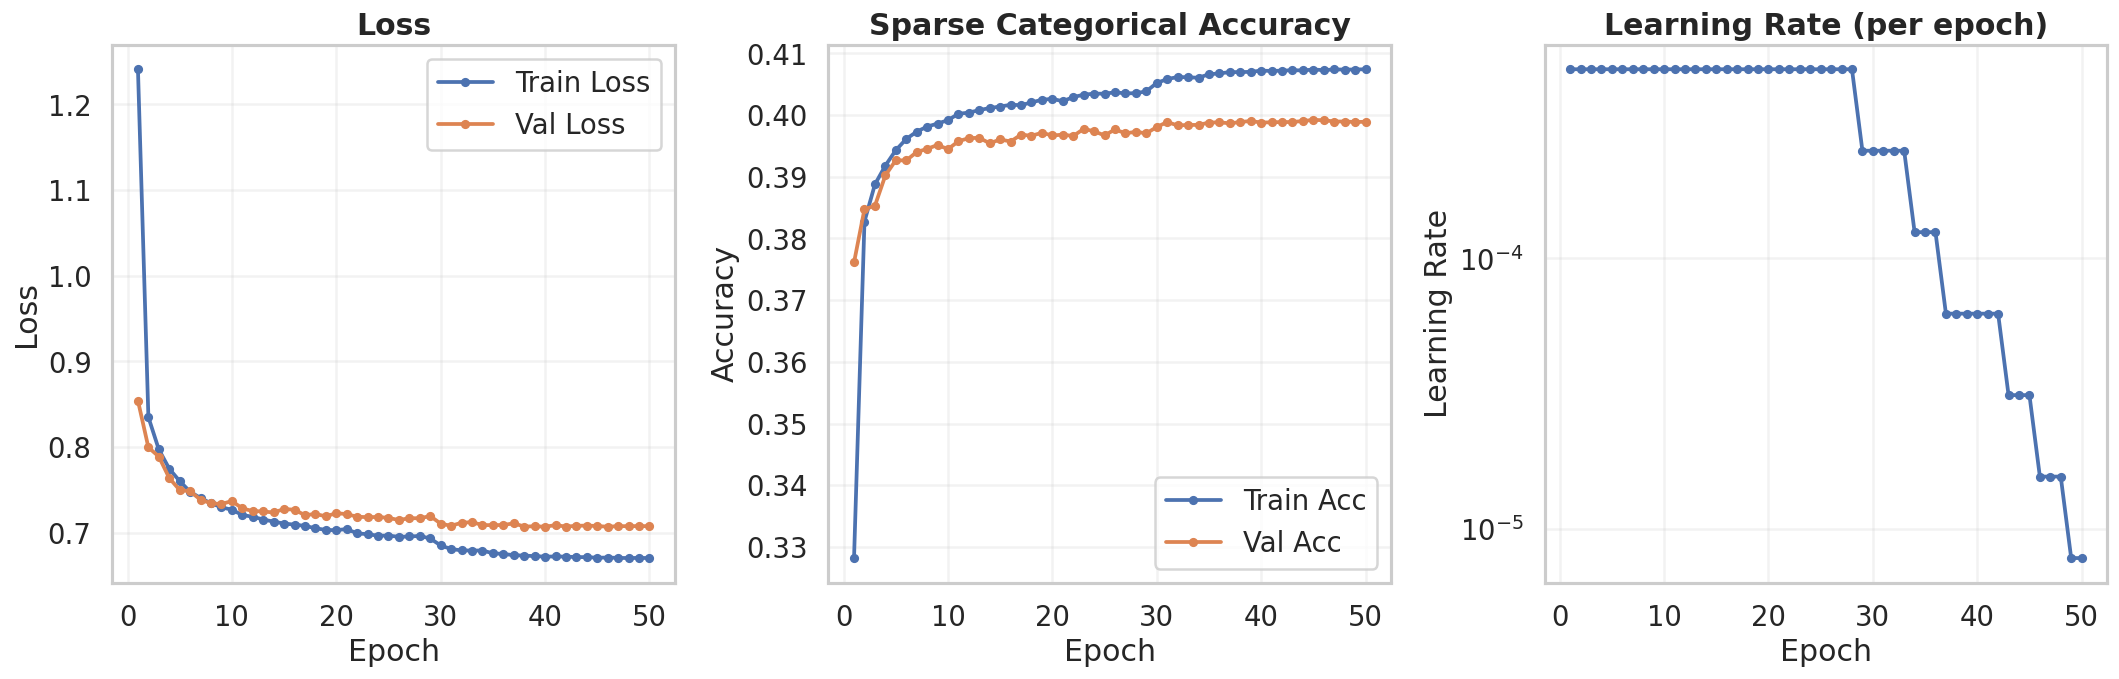

In [26]:
epochs = range(1, len(history.history["loss"]) + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Loss (train & val)
axes[0].plot(epochs, history.history["loss"], label="Train Loss", marker='.')
if "val_loss" in history.history:
    axes[0].plot(epochs, history.history["val_loss"], label="Val Loss", marker='.')
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.25)

# 2) Accuracy (sparse_categorical_accuracy)
acc_key = "sparse_categorical_accuracy"
val_acc_key = "val_" + acc_key
if acc_key in history.history:
    axes[1].plot(epochs, history.history[acc_key], label="Train Acc", marker='.')
if val_acc_key in history.history:
    axes[1].plot(epochs, history.history[val_acc_key], label="Val Acc", marker='.')
axes[1].set_title("Sparse Categorical Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.25)

# 3) Learning rate (Saved by lr_logger)
# The length of lr_logger.lrs should be equal to the number of epochs recorded during training
lrs = getattr(lr_logger, "lrs", None)
if lrs is None or len(lrs) == 0:
    current_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
    lrs = [current_lr] * len(epochs)
axes[2].plot(epochs, lrs, marker='.')
axes[2].set_title("Learning Rate (per epoch)")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_yscale("log")
axes[2].grid(alpha=0.25)

plt.tight_layout()
plt.show()

# **Load best weights from checkpoint**

In [27]:
if os.path.exists(CHECKPOINT_WEIGHTS):
    try:
        model.load_weights(CHECKPOINT_WEIGHTS)
        print("Loaded best weights from checkpoint.")
    except Exception as e:
        print("Could not load checkpoint weights:", e)


Loaded best weights from checkpoint.


# **Character-level Confusion Matrix**

In [28]:
def collect_char_confusion(words, gold_roots, decode_fn, max_samples=None):
    """
    Counts true/predicted character pairs across the test set.
    Uses a special <EOS> symbol for positions beyond string length.
    
    Args:
        words: List of input words
        gold_roots: List of ground truth roots
        decode_fn: Function that takes a word and returns predicted root
        max_samples: Maximum number of samples to process (None = all)
    
    Returns:
        mat: Confusion matrix (true_chars x pred_chars)
        true_chars: List of unique true characters
        pred_chars: List of unique predicted characters
    """
    if max_samples is None:
        max_samples = len(words)

    pair_counter = Counter()
    
    for i in range(max_samples):
        w = words[i]
        g = gold_roots[i]        # Ground truth root
        p = decode_fn(w)         # Predicted root

        # Align characters by padding shorter string with <EOS>
        maxlen = max(len(g), len(p))
        for j in range(maxlen):
            true_ch = g[j] if j < len(g) else "<EOS>"
            pred_ch = p[j] if j < len(p) else "<EOS>"
            pair_counter[(true_ch, pred_ch)] += 1

    # Build index mappings for matrix construction
    true_chars = sorted({t for (t, _) in pair_counter.keys()})
    pred_chars = sorted({p for (_, p) in pair_counter.keys()})

    true_index = {ch: i for i, ch in enumerate(true_chars)}
    pred_index = {ch: i for i, ch in enumerate(pred_chars)}

    # Construct confusion matrix
    mat = np.zeros((len(true_chars), len(pred_chars)), dtype=np.int32)
    for (t, p), c in pair_counter.items():
        mat[true_index[t], pred_index[p]] += c

    return mat, true_chars, pred_chars


def plot_char_confusion(mat, true_chars, pred_chars, max_chars=30):
    """
    Plots a heatmap of the character-level confusion matrix.
    Shows only the top 'max_chars' most frequent true characters.
    
    Args:
        mat: Confusion matrix from collect_char_confusion()
        true_chars: List of true characters (row labels)
        pred_chars: List of predicted characters (column labels)
        max_chars: Number of top characters to display
    
    Returns:
        fig: Matplotlib figure object
    """
    # Select top characters by row sum (most frequent true chars)
    row_sums = mat.sum(axis=1)
    top_idx = np.argsort(row_sums)[::-1][:max_chars]

    sub_mat = mat[top_idx][:, :]
    sub_true = [true_chars[i] for i in top_idx]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(sub_mat, aspect="auto", interpolation="nearest", cmap="Blues")

    # Set axis labels
    ax.set_xticks(range(len(pred_chars)))
    ax.set_xticklabels(pred_chars, rotation=90, fontsize=8)
    ax.set_yticks(range(len(sub_true)))
    ax.set_yticklabels(sub_true, fontsize=8)

    ax.set_xlabel("Predicted Character")
    ax.set_ylabel("True Character")
    ax.set_title("Character-level Confusion Matrix (Top True Characters)")

    plt.colorbar(im, ax=ax, label="Count")
    fig.tight_layout()
    
    return fig

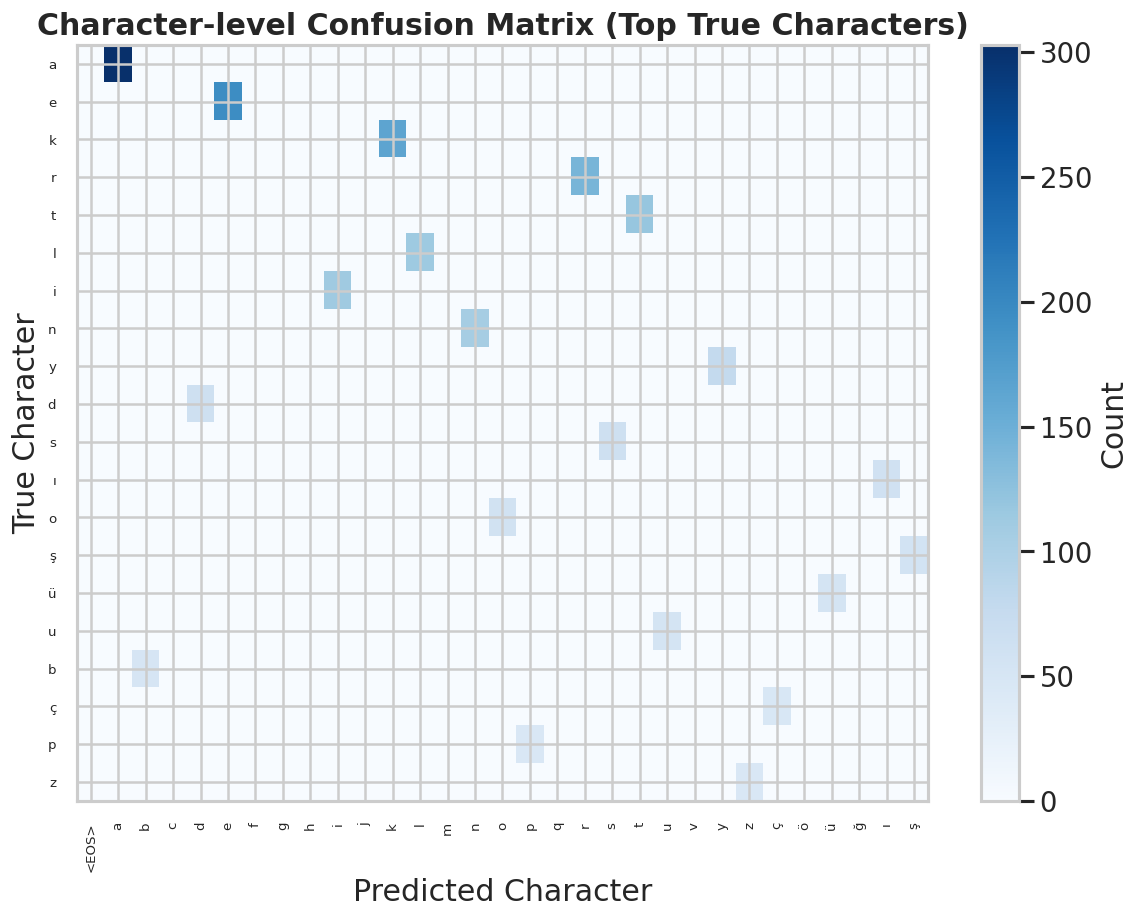


Most confused character pairs:
  '<EOS>' → 'i': 1 times
  '<EOS>' → 'l': 1 times
  '<EOS>' → 'n': 1 times
  'd' → '<EOS>': 1 times
  'i' → '<EOS>': 1 times


In [29]:
# Analyze which characters are most frequently confused by the model
# Use cached predictions
max_samples = 500
cached_preds = [(w, all_greedy_preds[w]) for w in words_test[:max_samples]]
mat, true_chars, pred_chars = collect_char_confusion(
    words_test[:max_samples], 
    roots_test[:max_samples], 
    lambda w: all_greedy_preds.get(w, predict_root_greedy(w)),
    max_samples=max_samples
)
fig = plot_char_confusion(mat, true_chars, pred_chars, max_chars=20)
plt.show()
# Print most confused character pairs
print("\nMost confused character pairs:")
confusion_pairs = []
for (t, p), count in Counter(
    {(t, p): mat[true_chars.index(t), pred_chars.index(p)] 
     for t in true_chars for p in pred_chars if t != p}
).most_common(10):
    if count > 0:
        print(f"  '{t}' → '{p}': {count} times")


# **Model Testing with Sample Words**

In [30]:
test_words = [
    "evimdeyken", "kitapta", "görüyordum", "koşacaklarmış",
    "bulutlardayım", "tevekkül", "cömert", "etkilendim",
    "önderimiz", "anlamlandıramadıklarımdan"
]

print("\nGreedy predictions:")
for w in test_words:
    word_norm = w.casefold()
    print(w, "→", all_greedy_preds.get(word_norm, predict_root_greedy(word_norm)))

print("\nBeam search predictions (beam_size={}):".format(BEAM_SIZE))
for w in test_words:
    word_norm = w.casefold()
    print(w, "→", all_beam_preds.get(word_norm, beam_search_decode(model, word_norm, beam_size=BEAM_SIZE)))



Greedy predictions:
evimdeyken → ev
kitapta → kitap
görüyordum → gör
koşacaklarmış → koş
bulutlardayım → bulut
tevekkül → tevekkül
cömert → cömert
etkilendim → et
önderimiz → ön
anlamlandıramadıklarımdan → anla

Beam search predictions (beam_size=5):
evimdeyken → ev
kitapta → kitap
görüyordum → gör
koşacaklarmış → koş
bulutlardayım → bulut
tevekkül → tevekkül
cömert → cöm
etkilendim → et
önderimiz → ön
anlamlandıramadıklarımdan → anla


# **Attention Visualization**

Attention Visualization Examples:

evimdeyken → ev


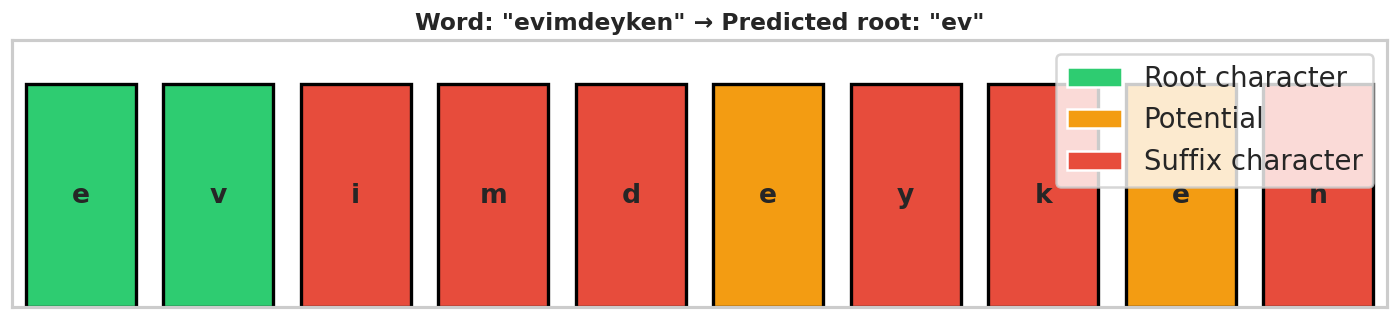


kitapta → kitap


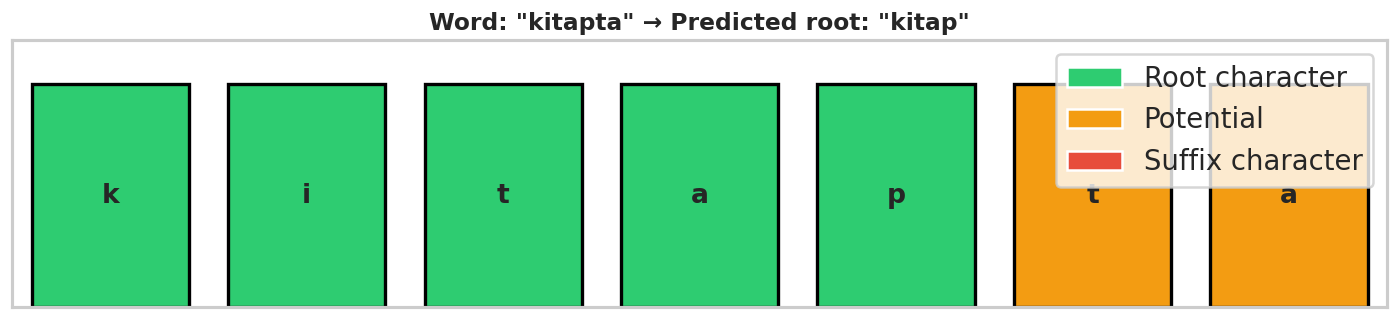


görüyordum → gör


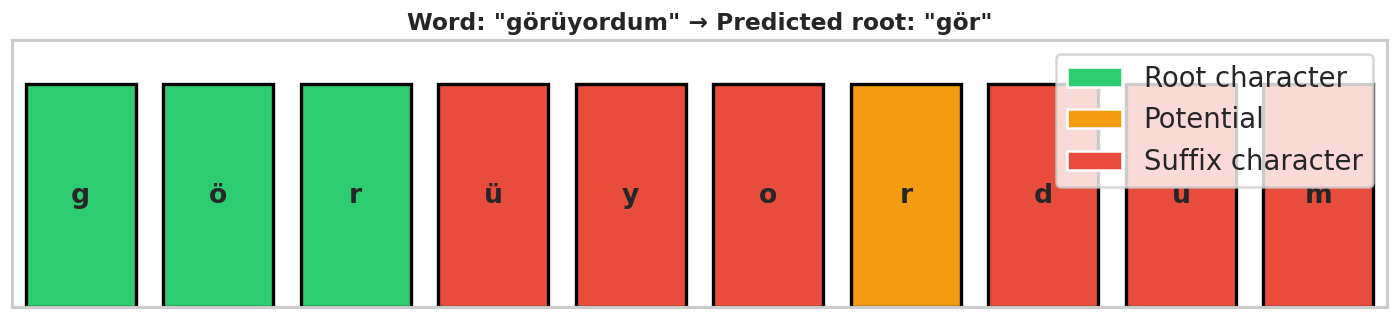


koşacaklarmış → koş


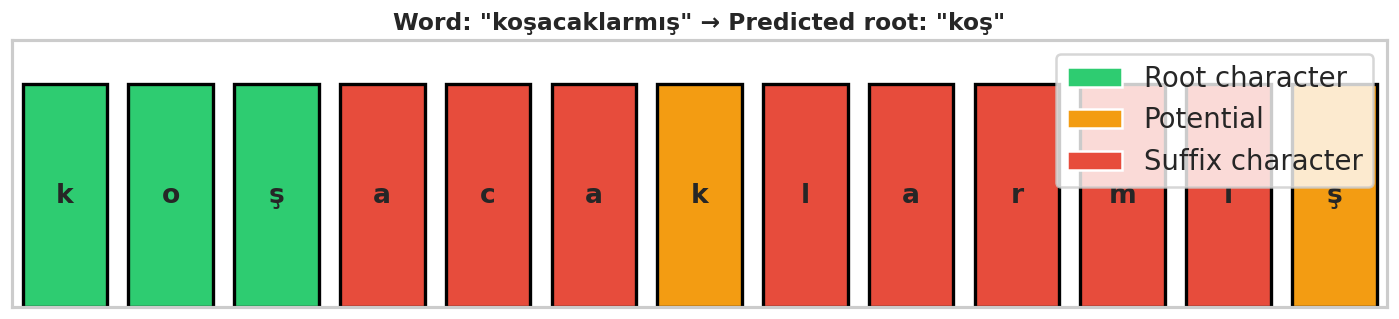


cömert → cömert


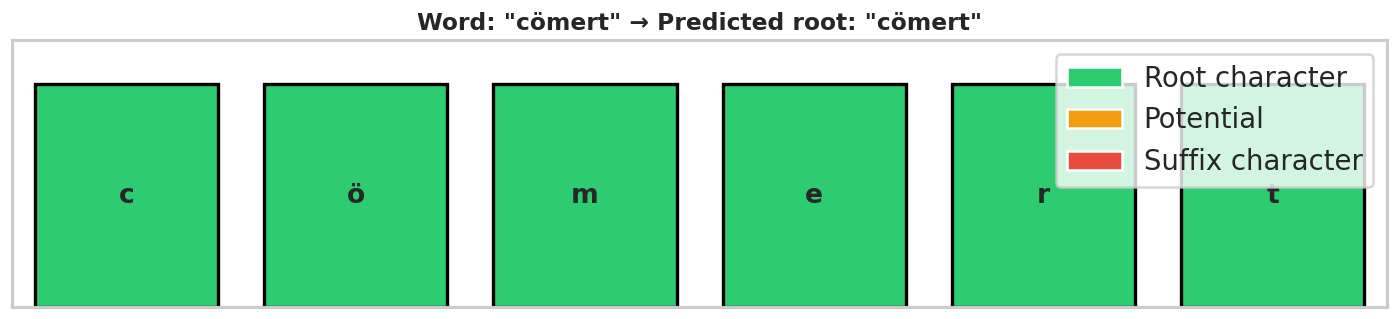

In [31]:
def visualize_attention_simple(word, pred_root):
    """
    Simple visualization showing which characters belong to the predicted root.
    
    Colors:
        - Green: Character matches root at same position
        - Orange: Character exists in root but different position
        - Red: Character is part of suffix (not in root)
    
    Args:
        word: Input word
        pred_root: Predicted root from the model
    """
    fig, ax = plt.subplots(figsize=(12, 3))
    
    word_chars = list(word)
    root_chars = list(pred_root)
    
    # Assign color to each character
    colors = []
    for i, char in enumerate(word_chars):
        if i < len(root_chars) and char == root_chars[i]:
            colors.append('#2ecc71')  # Green - exact root match
        elif char in root_chars:
            colors.append('#f39c12')  # Orange - potential root char
        else:
            colors.append('#e74c3c')  # Red - suffix character
    
    # Create bar chart
    x = range(len(word_chars))
    bars = ax.bar(x, [1]*len(word_chars), color=colors, edgecolor='black', linewidth=2)
    
    # Add character labels
    for i, char in enumerate(word_chars):
        ax.text(i, 0.5, char, ha='center', va='center', fontsize=16, fontweight='bold')
    
    ax.set_xlim(-0.5, len(word_chars) - 0.5)
    ax.set_ylim(0, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Word: "{word}" → Predicted root: "{pred_root}"', fontsize=14, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', label='Root character'),
        Patch(facecolor='#f39c12', label='Potential'),
        Patch(facecolor='#e74c3c', label='Suffix character')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()


# VISUALIZATION EXAMPLES
print("Attention Visualization Examples:")
print("=" * 50)

test_examples = ["evimdeyken", "kitapta", "görüyordum", "koşacaklarmış", "cömert"]

for word in test_examples:
    pred = all_greedy_preds.get(word, predict_root_greedy(word))
    print(f"\n{word} → {pred}")
    visualize_attention_simple(word, pred)

# **Word-level Exact Match Metric**

In [32]:
def evaluate_dataset(words, gold_roots, decode_fn, max_samples=None):
    """
    Evaluates word-level exact root match accuracy.
    
    Args:
        words: List of input words
        gold_roots: List of ground truth roots
        decode_fn: Decoding function (greedy or beam search)
        max_samples: Maximum samples to evaluate (None = all)
    
    Returns:
        acc: Accuracy (correct / total)
        preds: List of (word, gold_root, pred_root) tuples
    """
    correct = 0
    total = len(words) if max_samples is None else min(len(words), max_samples)
    preds = []

    for i in range(total):
        w = words[i]
        g = gold_roots[i]
        p = decode_fn(w)
        
        preds.append((w, g, p))
        
        if p == g:
            correct += 1

    acc = correct / total
    return acc, preds

# **Greedy vs Beam Search Comparison**

In [33]:
print("Using pre-computed predictions for evaluation...")

# Calculate greedy accuracy from cache
greedy_correct = sum(1 for w, g in zip(words_test, roots_test) if all_greedy_preds[w] == g)
greedy_acc = greedy_correct / len(words_test)
greedy_preds = [(w, g, all_greedy_preds[w]) for w, g in zip(words_test, roots_test)]

# Calculate beam accuracy from cache
beam_correct = sum(1 for w, g in zip(words_test, roots_test) if all_beam_preds[w] == g)
beam_acc = beam_correct / len(words_test)
beam_preds = [(w, g, all_beam_preds[w]) for w, g in zip(words_test, roots_test)]

print(f"\n{'='*40}")
print(f"Greedy Accuracy    : {greedy_acc:.4f}")
print(f"Beam({BEAM_SIZE}) Accuracy : {beam_acc:.4f}")
print(f"Improvement        : {(beam_acc - greedy_acc)*100:+.2f}%")
print(f"{'='*40}")


Using pre-computed predictions for evaluation...

Greedy Accuracy    : 0.9928
Beam(5) Accuracy : 0.9922
Improvement        : -0.06%


In [34]:
errors = []
for (w, g, p) in greedy_preds:
    if g != p:
        errors.append((w, g, p))

print(f"Total errors: {len(errors)} / {len(greedy_preds)} ({len(errors)/len(greedy_preds):.1%})")

# Print first 20 error examples
print("\nSample errors (word → gold | predicted):")
for i in range(min(20, len(errors))):
    w, g, p = errors[i]
    print(f"  {i+1:2d}) {w:20s} → {g:10s} | {p}")

Total errors: 13 / 1802 (0.7%)

Sample errors (word → gold | predicted):
   1) peşine               → peş        | peşin
   2) eksilmeyen           → eksi       | eksil
   3) yedili               → yedi       | ye
   4) ruha                 → ruh        | ruha
   5) dişbudak             → diş        | dişbudak
   6) aşkla                → aşk        | aşkla
   7) panterse             → panter     | panterse
   8) kamaşmış             → kama       | kamaş
   9) onsuzum              → o          | on
  10) bayanın              → bayan      | baya
  11) elmam                → elma       | elmam
  12) mantolu              → manto      | mantol
  13) yudum                → yut        | yud


# **Rare vs Frequent Root Performance**

In [35]:
# Analyze model performance on rare roots (≤3 occurrences) vs frequent roots
# Using cached predictions

# Calculate root frequencies from training data
root_freq = Counter(roots_train)

# Analyze using cached predictions
preds = [(g, all_beam_preds[w]) for w, g in zip(words_test, roots_test)]

rare_threshold = 3
rare_correct, rare_total = 0, 0
freq_correct, freq_total = 0, 0

for (g, p) in preds:
    if root_freq[g] <= rare_threshold:
        rare_total += 1
        if g == p:
            rare_correct += 1
    else:
        freq_total += 1
        if g == p:
            freq_correct += 1

rare_acc = rare_correct / max(1, rare_total)
freq_acc = freq_correct / max(1, freq_total)

print(f"Rare roots (≤3 occurrences): {rare_total:4d} samples, Accuracy: {rare_acc:.4f}")
print(f"Frequent roots (>3)        : {freq_total:4d} samples, Accuracy: {freq_acc:.4f}")
print(f"Difference                 : {(freq_acc - rare_acc)*100:+.2f}%")


Rare roots (≤3 occurrences):  405 samples, Accuracy: 0.9778
Frequent roots (>3)        : 1397 samples, Accuracy: 0.9964
Difference                 : +1.86%


# **Final Summary**

In [36]:
print("=" * 50)
print("           FINAL RESULTS SUMMARY")
print("=" * 50)
print(f"  Greedy Accuracy        : {greedy_acc:.4f} ({greedy_acc*100:.2f}%)")
print(f"  Beam({BEAM_SIZE}) Accuracy      : {beam_acc:.4f} ({beam_acc*100:.2f}%)")
print(f"  Frequent Root Accuracy : {freq_acc:.4f} ({freq_acc*100:.2f}%)")
print(f"  Rare Root Accuracy     : {rare_acc:.4f} ({rare_acc*100:.2f}%)")
print("=" * 50)
print(f"  Beam vs Greedy Gain    : {(beam_acc - greedy_acc)*100:+.2f}%")
print(f"  Freq vs Rare Gap       : {(freq_acc - rare_acc)*100:+.2f}%")
print("=" * 50)

           FINAL RESULTS SUMMARY
  Greedy Accuracy        : 0.9928 (99.28%)
  Beam(5) Accuracy      : 0.9922 (99.22%)
  Frequent Root Accuracy : 0.9964 (99.64%)
  Rare Root Accuracy     : 0.9778 (97.78%)
  Beam vs Greedy Gain    : -0.06%
  Freq vs Rare Gap       : +1.86%


# **Post-processing: Root Correction**

In [37]:
# Improve predictions by correcting unknown roots using frequency data

# Root frequencies from training data (calculated earlier as ROOT_FREQ)
root_freq = ROOT_FREQ

# Derivational suffix candidates for aggressive root generation
# DERIV_SUFFIX_CANDIDATES = [
#     "l", "le", "la", "len", "lan",
#     "leş", "leştir", "si", "sı", "cık", "cığım", "lık", "lik", "üş"
# ]

DERIV_SUFFIX_CANDIDATES = [
    # Noun → Verb
    "l", "la", "le",
    "lan", "len",
    "laş", "leş",
    "laştır", "leştir",
    
    # Noun → Noun
    "lık", "lik", "luk", "lük",
    "cı", "ci", "cu", "cü",
    "çı", "çi", "çu", "çü",
    "cık", "cik", "cuk", "cük",
    "çık", "çik", "çuk", "çük",
    "daş", "deş",
    
    # Noun → Adjective
    "lı", "li", "lu", "lü",
    "sız", "siz", "suz", "süz",
    "sal", "sel",
    
    # Verb → Noun
    "ma", "me",
    "ış", "iş", "uş", "üş",
    "ıcı", "ici", "ucu", "ücü",
    "ık", "ik", "uk", "ük",
    "gı", "gi", "gu", "gü",
    
    # Verb → Verb (causative/passive)
    "dır", "dir", "dur", "dür",
    "tır", "tir", "tur", "tür",
    "ıl", "il", "ul", "ül",
    "ın", "in", "un", "ün",
]


def generate_prefix_candidates(word: str):
    """
    Returns prefixes of the word that exist as roots in training data.
    """
    cands = set()
    for i in range(2, len(word) + 1):
        pref = word[:i]
        if pref in root_freq:
            cands.add(pref)
    return list(cands)


def generate_root_candidates(word, pred_root):
    """
    Generates root candidates using multiple strategies:
    1. Prefixes of the word that exist in training roots
    2. Truncated versions of pred_root (removing 1-3 chars)
    3. pred_root + derivational suffixes
    """
    cands = set()
    cands.add(pred_root)

    # 1) Prefixes that are known roots
    for i in range(2, len(word) + 1):
        pref = word[:i]
        if pref in root_freq:
            cands.add(pref)

    # 2) Truncate pred_root by 1-3 characters
    for k in (1, 2, 3):
        if len(pred_root) > k:
            trunc = pred_root[:-k]
            if trunc in root_freq:
                cands.add(trunc)

    # 3) Add derivational suffixes to pred_root
    for suf in DERIV_SUFFIX_CANDIDATES:
        alt = pred_root + suf
        if alt in root_freq:
            cands.add(alt)

    return list(cands)


def choose_best_root(word, pred_root):
    """
    Aggressive strategy: Scores candidates based on frequency and heuristics.
    """
    cands = generate_root_candidates(word, pred_root)
    if not cands:
        return pred_root

    best_root = pred_root
    best_score = -1.0

    for r in cands:
        freq = root_freq.get(r, 0)
        score = float(freq)

        # Bonus if candidate is a prefix of the word
        if word.startswith(r):
            score += 0.7

        # Penalize very short or very long roots
        if len(r) < 2:
            score -= 0.5
        if len(r) > len(word):
            score -= 1.0

        if score > best_score:
            best_score = score
            best_root = r

    return best_root


def choose_best_root_conservative(word: str, pred_root: str):
    """
    Conservative strategy:
    - If pred_root exists in training data, keep it unchanged.
    - If unknown, find the most frequent known root from word prefixes.
    """
    # 1) If model's prediction is a known root, don't modify
    if pred_root in root_freq:
        return pred_root

    # 2) Otherwise, collect prefix candidates
    prefix_cands = generate_prefix_candidates(word)
    if not prefix_cands:
        return pred_root

    # 3) Select the most frequent prefix root
    best_root = None
    best_freq = -1
    for r in prefix_cands:
        f = root_freq.get(r, 0)
        if f > best_freq:
            best_freq = f
            best_root = r

    return best_root if best_root else pred_root


# EVALUATE POST-PROCESSING USING CACHED PREDICTIONS

# Calculate post-processing accuracy from cache
post_correct = sum(1 for w, g in zip(words_test, roots_test) 
                   if choose_best_root_conservative(w, all_beam_preds[w]) == g)
post_acc = post_correct / len(words_test)
post_preds = [(w, g, choose_best_root_conservative(w, all_beam_preds[w])) 
              for w, g in zip(words_test, roots_test)]

print(f"Beam + Conservative Post-processing Accuracy: {post_acc:.4f}")
print(f"Improvement over raw Beam: {(post_acc - beam_acc)*100:+.2f}%")


Beam + Conservative Post-processing Accuracy: 0.9950
Improvement over raw Beam: +0.28%


# **Export: Root Frequencies**

In [38]:
# Save root frequencies for later use (e.g., production deployment)
with open("root_freq.json", "w", encoding="utf-8") as f:
    json.dump(dict(ROOT_FREQ), f, ensure_ascii=False, indent=2)

print(f"Saved {len(ROOT_FREQ)} root frequencies to 'root_freq.json'")

Saved 3091 root frequencies to 'root_freq.json'


# **Export: Character Vocabulary**

In [39]:
# Save vocabulary for production deployment (use existing char2idx)
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(char2idx, f, ensure_ascii=False, indent=2)
    
print(f"Saved vocabulary with {len(char2idx)} characters to 'vocab.json'")

Saved vocabulary with 36 characters to 'vocab.json'


# **Export: Inverse Vocabulary**

In [40]:
# Save index-to-character mapping for decoding predictions

inv_vocab = {i: c for c, i in char2idx.items()}

with open("inv_vocab.json", "w", encoding="utf-8") as f:
    json.dump(inv_vocab, f, ensure_ascii=False, indent=2)

print(f"Saved inverse vocabulary with {len(inv_vocab)} entries to 'inv_vocab.json'")

Saved inverse vocabulary with 36 entries to 'inv_vocab.json'
